In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from hydra import compose, initialize
from hydra.utils import instantiate
from scipy.stats import kendalltau, spearmanr

plt.rcParams["font.family"] = "serif"

import lightning as L
from lightning.pytorch.utilities import move_data_to_device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2.ckpt"

with initialize(config_path="../", version_base=None):
    cfg = compose(
        "config_train_npe",
        {
            "train.pretrained_weights=" + ckpt,
        },
    )

seed = L.seed_everything(cfg.train.seed)

Seed set to 123123


**Configure the test dataloader:**

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

**Load encoder weights:**

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict, strict=False)
encoder = encoder.eval()

**Store shear and convergence maps for the test images:**

In [5]:
torch.manual_seed(0)

num_tiles_per_side = 8
num_bins = 4
shear1_true = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
shear1_pred = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
shear1_std = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
shear2_true = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
shear2_pred = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
shear2_std = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
convergence_true = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
convergence_pred = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)
convergence_std = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device
)

ra = torch.zeros(len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device)
dec = torch.zeros(len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, device=device)
test_loss = torch.zeros(len(test_dl), device=device)

num_samples = 3
convergence_pred_samples = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, num_samples, device=device
)
shear1_pred_samples = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, num_samples, device=device
)
shear2_pred_samples = torch.zeros(
    len(test_dl), num_tiles_per_side, num_tiles_per_side, num_bins, num_samples, device=device
)

i = -1
for b in test_dl:
    i += 1
    print(i)
    batch = move_data_to_device(b, device)

    shear1_true[i] = batch["tile_catalog"]["shear_1"].squeeze()
    shear2_true[i] = batch["tile_catalog"]["shear_2"].squeeze()
    convergence_true[i] = batch["tile_catalog"]["convergence"].squeeze()
    ra[i] = batch["tile_catalog"]["ra"].squeeze()
    dec[i] = batch["tile_catalog"]["dec"].squeeze()

    with torch.no_grad():
        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)

        x_cat_marginal = encoder.net(inputs).squeeze(0)
        shear1_pred[i] = x_cat_marginal[:, :, 0:num_bins].squeeze()
        shear1_std[i] = x_cat_marginal[:, :, num_bins : (2 * num_bins)].exp().sqrt().squeeze()
        shear2_pred[i] = x_cat_marginal[:, :, (2 * num_bins) : (3 * num_bins)].squeeze()
        shear2_std[i] = x_cat_marginal[:, :, (3 * num_bins) : (4 * num_bins)].exp().sqrt().squeeze()
        convergence_pred[i] = x_cat_marginal[:, :, (4 * num_bins) : (5 * num_bins)].squeeze()
        convergence_std[i] = (
            x_cat_marginal[:, :, (5 * num_bins) : (6 * num_bins)].exp().sqrt().squeeze()
        )
        convergence_pred_samples[i] = rearrange(
            torch.distributions.Normal(convergence_pred[i], convergence_std[i]).sample([3]),
            "s h w b -> h w b s",
        )
        shear1_pred_samples[i] = rearrange(
            torch.distributions.Normal(shear1_pred[i], shear1_std[i]).sample([3]),
            "s h w b -> h w b s",
        )
        shear2_pred_samples[i] = rearrange(
            torch.distributions.Normal(shear2_pred[i], shear2_std[i]).sample([3]),
            "s h w b -> h w b s",
        )
        test_loss[i] = encoder._compute_loss(batch, None)

0


/home/twhit/blissWL/.venv/lib/python3.12/site-packages/lightning/pytorch/core/module.py:451: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


**Compute test RMSEs:**

In [6]:
for b in range(num_bins):
    print(f"redshift bin {b}")
    print(f"shear 1 test RMSE = {((shear1_true[..., b] - shear1_pred[..., b]) ** 2).mean().sqrt()}")
    print(f"shear 2 test RMSE = {((shear2_true[..., b] - shear2_pred[..., b]) ** 2).mean().sqrt()}")
    print(
        f"convergence test RMSE = {((convergence_true[..., b] - convergence_pred[..., b]) ** 2).mean().sqrt()}\n"
    )

redshift bin 0
shear 1 test RMSE = 0.004616932012140751
shear 2 test RMSE = 0.005078418646007776
convergence test RMSE = 0.0042905197478830814

redshift bin 1
shear 1 test RMSE = 0.00901101902127266
shear 2 test RMSE = 0.007531836163252592
convergence test RMSE = 0.008021601475775242

redshift bin 2
shear 1 test RMSE = 0.011511273682117462
shear 2 test RMSE = 0.010105786845088005
convergence test RMSE = 0.0102619593963027

redshift bin 3
shear 1 test RMSE = 0.01472593192011118
shear 2 test RMSE = 0.014634164050221443
convergence test RMSE = 0.01588885299861431



**Compute Pearson correlation coefficients:**

In [7]:
for b in range(num_bins):
    print(f"redshift bin {b}")
    print(
        f"shear 1 pearson correlation = {np.corrcoef(shear1_true[..., b].flatten().cpu(), shear1_pred[..., b].flatten().cpu())[1, 0]}"
    )
    print(
        f"shear 2 pearson correlation = {np.corrcoef(shear2_true[..., b].flatten().cpu(), shear2_pred[..., b].flatten().cpu())[1, 0]}"
    )
    print(
        f"convergence pearson correlation = {np.corrcoef(convergence_true[..., b].flatten().cpu(), convergence_pred[..., b].flatten().cpu())[1, 0]}\n"
    )

redshift bin 0
shear 1 pearson correlation = 0.24939686582555434
shear 2 pearson correlation = 0.29516993467073627
convergence pearson correlation = 0.6151826601091808

redshift bin 1
shear 1 pearson correlation = 0.313594101275857
shear 2 pearson correlation = 0.37671696512513747
convergence pearson correlation = 0.7106145338384857

redshift bin 2
shear 1 pearson correlation = 0.3672519681919576
shear 2 pearson correlation = 0.4005989213751525
convergence pearson correlation = 0.7400306181337973

redshift bin 3
shear 1 pearson correlation = 0.3425273875259546
shear 2 pearson correlation = 0.36961272248221966
convergence pearson correlation = 0.6922921099546263



**Compute Spearman correlation coefficients:**

In [8]:
for b in range(num_bins):
    print(f"redshift bin {b}")
    print(
        f"shear 1 spearman correlation = {spearmanr(shear1_true[..., b].flatten().cpu(), shear1_pred[..., b].flatten().cpu())[0]}"
    )
    print(
        f"shear 2 spearman correlation = {spearmanr(shear2_true[..., b].flatten().cpu(), shear2_pred[..., b].flatten().cpu())[0]}"
    )
    print(
        f"convergence spearman correlation = {spearmanr(convergence_true[..., b].flatten().cpu(), convergence_pred[..., b].flatten().cpu())[0]}\n"
    )

redshift bin 0
shear 1 spearman correlation = 0.2638941591498112
shear 2 spearman correlation = 0.27584178056076675
convergence spearman correlation = 0.5578091076485177

redshift bin 1
shear 1 spearman correlation = 0.2998209096632737
shear 2 spearman correlation = 0.33475774955654813
convergence spearman correlation = 0.6646598225544157

redshift bin 2
shear 1 spearman correlation = 0.3598731662341454
shear 2 spearman correlation = 0.3504209049191434
convergence spearman correlation = 0.6980415023017151

redshift bin 3
shear 1 spearman correlation = 0.33778585188778376
shear 2 spearman correlation = 0.3194441297343551
convergence spearman correlation = 0.6330045777611597



**Compute Kendall correlation coefficients:**

In [9]:
for b in range(num_bins):
    print(f"redshift bin {b}")
    print(
        f"shear 1 kendall correlation = {kendalltau(shear1_true[..., b].flatten().cpu(), shear1_pred[..., b].flatten().cpu())[0]}"
    )
    print(
        f"shear 2 kendall correlation = {kendalltau(shear2_true[..., b].flatten().cpu(), shear2_pred[..., b].flatten().cpu())[0]}"
    )
    print(
        f"convergence kendall correlation = {kendalltau(convergence_true[..., b].flatten().cpu(), convergence_pred[..., b].flatten().cpu())[0]}\n"
    )

redshift bin 0
shear 1 kendall correlation = 0.17972534253212136
shear 2 kendall correlation = 0.18729162643770905
convergence kendall correlation = 0.3936659644368178

redshift bin 1
shear 1 kendall correlation = 0.2055908137833862
shear 2 kendall correlation = 0.23033262357314885
convergence kendall correlation = 0.4763617612964763

redshift bin 2
shear 1 kendall correlation = 0.2465896620642151
shear 2 kendall correlation = 0.24062517220629737
convergence kendall correlation = 0.5071888596602826

redshift bin 3
shear 1 kendall correlation = 0.22958771368803868
shear 2 kendall correlation = 0.2188915854951148
convergence kendall correlation = 0.45369434697054845



**Compute test loss:**

In [10]:
print(f"test loss = {test_loss.mean()}")

test loss = -39.626461029052734


**Scatterplots of true vs. posterior mode shear and convergence:**

In [11]:
alpha = 0.25
s = 1
fontsize = 12
ticklabelsize = 6
npe_color = "#1c692b"
axmin = -0.1
axmax = 0.1

*Redshift bin 1:*

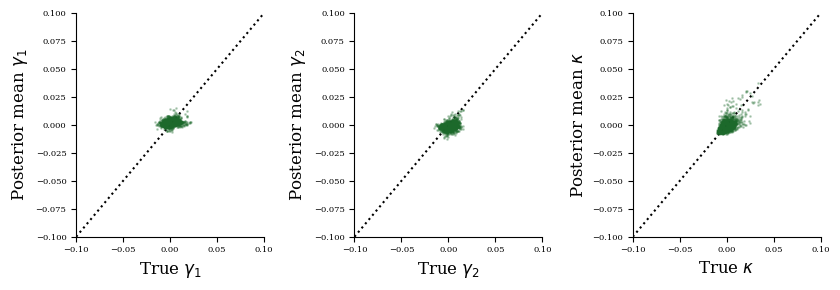

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3))
b = 0

_ = ax[0].scatter(
    shear1_true[..., b].flatten().cpu(),
    shear1_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[0].set_xlabel(r"True $\gamma_1$", fontsize=fontsize)
_ = ax[0].set_ylabel(r"Posterior mean $\gamma_1$", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[1].scatter(
    shear2_true[..., b].flatten().cpu(),
    shear2_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[1].set_xlabel(r"True $\gamma_2$", fontsize=fontsize)
_ = ax[1].set_ylabel(r"Posterior mean $\gamma_2$", fontsize=fontsize)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[2].scatter(
    convergence_true[..., b].flatten().cpu(),
    convergence_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[2].set_xlabel(r"True $\kappa$", fontsize=fontsize)
_ = ax[2].set_ylabel(r"Posterior mean $\kappa$", fontsize=fontsize)
_ = ax[2].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

fig.tight_layout()

fig.savefig(
    f"figures/scatterplots_bin{b + 1}.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

*Redshift bin 2:*

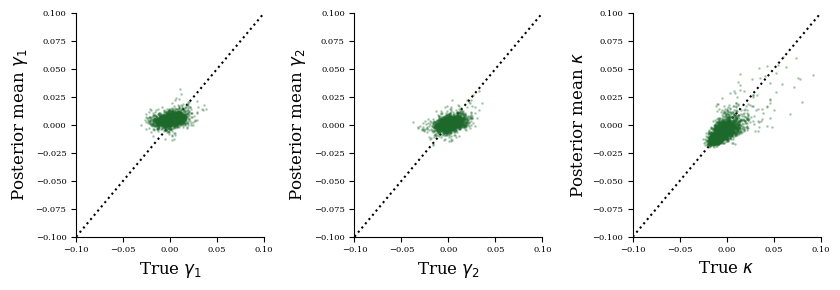

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3))
b = 1

_ = ax[0].scatter(
    shear1_true[..., b].flatten().cpu(),
    shear1_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[0].set_xlabel(r"True $\gamma_1$", fontsize=fontsize)
_ = ax[0].set_ylabel(r"Posterior mean $\gamma_1$", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[1].scatter(
    shear2_true[..., b].flatten().cpu(),
    shear2_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[1].set_xlabel(r"True $\gamma_2$", fontsize=fontsize)
_ = ax[1].set_ylabel(r"Posterior mean $\gamma_2$", fontsize=fontsize)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[2].scatter(
    convergence_true[..., b].flatten().cpu(),
    convergence_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[2].set_xlabel(r"True $\kappa$", fontsize=fontsize)
_ = ax[2].set_ylabel(r"Posterior mean $\kappa$", fontsize=fontsize)
_ = ax[2].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

fig.tight_layout()

fig.savefig(
    f"figures/scatterplots_bin{b + 1}.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

*Redshift bin 3:*

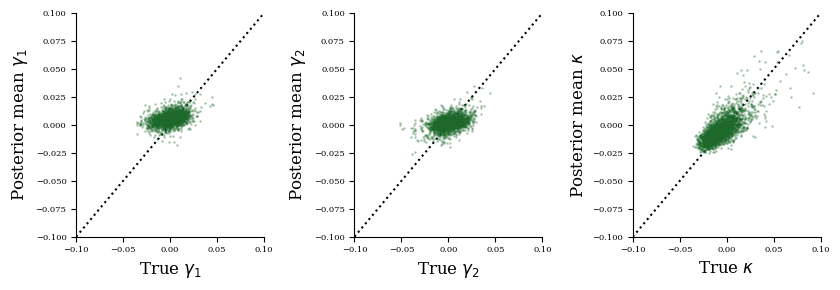

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3))
b = 2

_ = ax[0].scatter(
    shear1_true[..., b].flatten().cpu(),
    shear1_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[0].set_xlabel(r"True $\gamma_1$", fontsize=fontsize)
_ = ax[0].set_ylabel(r"Posterior mean $\gamma_1$", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[1].scatter(
    shear2_true[..., b].flatten().cpu(),
    shear2_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[1].set_xlabel(r"True $\gamma_2$", fontsize=fontsize)
_ = ax[1].set_ylabel(r"Posterior mean $\gamma_2$", fontsize=fontsize)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[2].scatter(
    convergence_true[..., b].flatten().cpu(),
    convergence_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[2].set_xlabel(r"True $\kappa$", fontsize=fontsize)
_ = ax[2].set_ylabel(r"Posterior mean $\kappa$", fontsize=fontsize)
_ = ax[2].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

fig.tight_layout()

fig.savefig(
    f"figures/scatterplots_bin{b + 1}.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

*Redshift bin 4:*

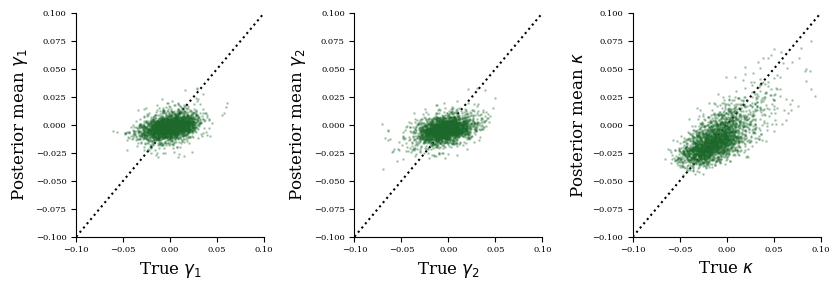

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3))
b = 3

_ = ax[0].scatter(
    shear1_true[..., b].flatten().cpu(),
    shear1_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[0].set_xlabel(r"True $\gamma_1$", fontsize=fontsize)
_ = ax[0].set_ylabel(r"Posterior mean $\gamma_1$", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[1].scatter(
    shear2_true[..., b].flatten().cpu(),
    shear2_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[1].set_xlabel(r"True $\gamma_2$", fontsize=fontsize)
_ = ax[1].set_ylabel(r"Posterior mean $\gamma_2$", fontsize=fontsize)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

_ = ax[2].scatter(
    convergence_true[..., b].flatten().cpu(),
    convergence_pred[..., b].flatten().cpu(),
    color=npe_color,
    alpha=alpha,
    s=s,
    zorder=1,
)
_ = ax[2].set_xlabel(r"True $\kappa$", fontsize=fontsize)
_ = ax[2].set_ylabel(r"Posterior mean $\kappa$", fontsize=fontsize)
_ = ax[2].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

fig.tight_layout()

fig.savefig(
    f"figures/scatterplots_bin{b + 1}.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

**Plot shear and convergence maps for the entire test set:**

In [16]:
ra_mean = ra.mean([1, 2, 3])
dec_mean = dec.mean([1, 2, 3])

dec_sort_idx = torch.argsort(dec_mean)

dec_bins = dec_sort_idx.view(8, 5)

sorted_indices = torch.zeros_like(dec_bins)
for i in range(8):
    ra_in_row = ra_mean[dec_bins[i]]
    ra_sort_idx = torch.argsort(-ra_in_row)
    sorted_indices[i] = dec_bins[i][ra_sort_idx]

idx = sorted_indices.flatten()

In [17]:
ra_sorted = rearrange(
    ra[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
dec_sorted = rearrange(
    dec[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear1_true_sorted = rearrange(
    shear1_true[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear1_pred_sorted = rearrange(
    shear1_pred[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear1_pred_samples_sorted = rearrange(
    shear1_pred_samples[idx].view(
        8, 5, num_tiles_per_side, num_tiles_per_side, num_bins, num_samples
    ),
    "h w nh nw b ns -> (h nh) (w nw) b ns",
)
shear1_std_sorted = rearrange(
    shear1_std[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear2_true_sorted = rearrange(
    shear2_true[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear2_pred_sorted = rearrange(
    shear2_pred[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
shear2_pred_samples_sorted = rearrange(
    shear2_pred_samples[idx].view(
        8, 5, num_tiles_per_side, num_tiles_per_side, num_bins, num_samples
    ),
    "h w nh nw b ns -> (h nh) (w nw) b ns",
)
shear2_std_sorted = rearrange(
    shear2_std[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
convergence_true_sorted = rearrange(
    convergence_true[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
convergence_pred_sorted = rearrange(
    convergence_pred[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)
convergence_pred_samples_sorted = rearrange(
    convergence_pred_samples[idx].view(
        8, 5, num_tiles_per_side, num_tiles_per_side, num_bins, num_samples
    ),
    "h w nh nw b ns -> (h nh) (w nw) b ns",
)
convergence_std_sorted = rearrange(
    convergence_std[idx].view(8, 5, num_tiles_per_side, num_tiles_per_side, num_bins),
    "h w nh nw b -> (h nh) (w nw) b",
)

In [18]:
interpolation = "none"

extent = [
    ra_sorted.max().cpu(),
    ra_sorted.min().cpu(),
    dec_sorted.min().cpu(),
    dec_sorted.max().cpu(),
]

*Convergence:*

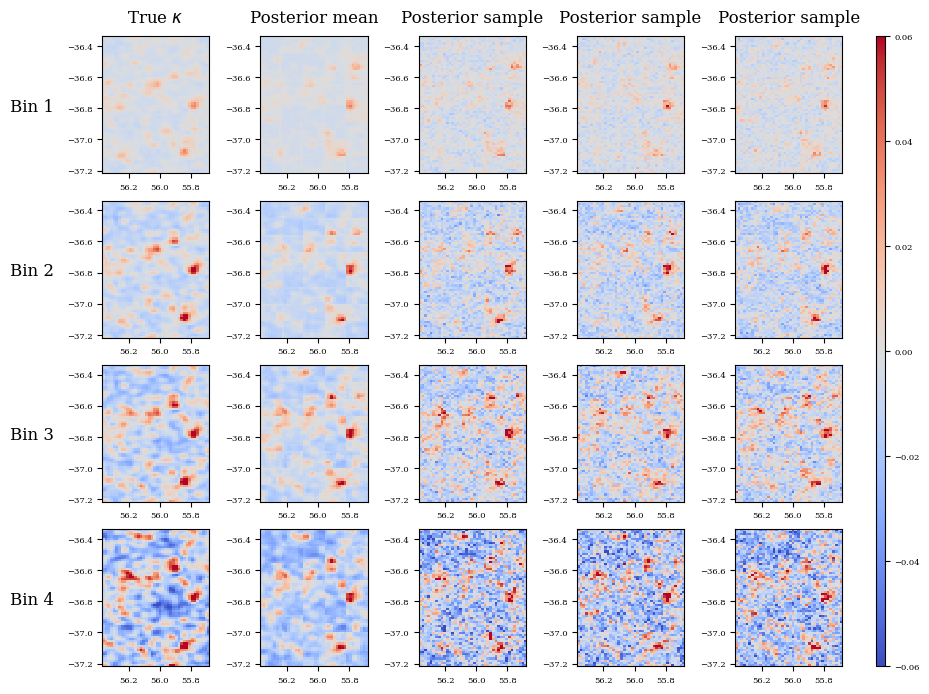

In [19]:
fig, ax = plt.subplots(4, 5, figsize=(8.5, 7))
fontsize = 12
ticklabelsize = 6
vmin = -0.06
vmax = 0.06

for b in range(4):
    # True
    _ = ax[b, 0].imshow(
        convergence_true_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Posterior mean
    _ = ax[b, 1].imshow(
        convergence_pred_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Sample 1
    _ = ax[b, 2].imshow(
        convergence_pred_samples_sorted[..., b, 0].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Sample 2
    _ = ax[b, 3].imshow(
        convergence_pred_samples_sorted[..., b, 1].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Sample 3
    tmp = ax[b, 4].imshow(
        convergence_pred_samples_sorted[..., b, 2].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

_ = ax[0, 0].set_title(r"True $\kappa$", fontsize=fontsize, pad=10)
_ = ax[0, 1].set_title("Posterior mean", fontsize=fontsize, pad=10)
_ = ax[0, 2].set_title("Posterior sample", fontsize=fontsize, pad=10)
_ = ax[0, 3].set_title("Posterior sample", fontsize=fontsize, pad=10)
_ = ax[0, 4].set_title("Posterior sample", fontsize=fontsize, pad=10)
_ = ax[0, 0].set_ylabel("Bin 1", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[1, 0].set_ylabel("Bin 2", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[2, 0].set_ylabel("Bin 3", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[3, 0].set_ylabel("Bin 4", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize=ticklabelsize)
fig.colorbar(tmp, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

for a in ax.flat:
    a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.savefig(
    "figures/posteriormeanconvergencemaps.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

*Shear:*

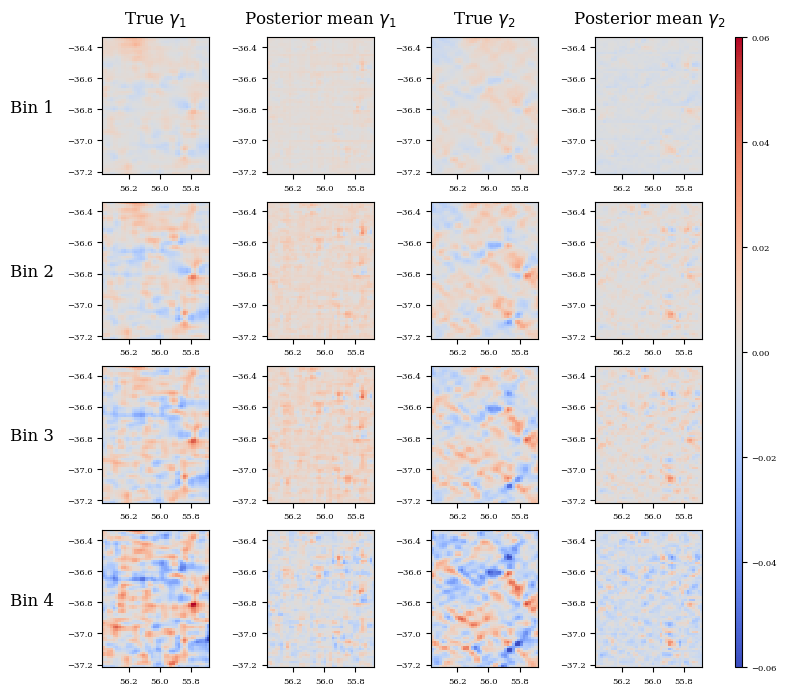

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
fontsize = 12
ticklabelsize = 6
vmin = -0.06
vmax = 0.06

for b in range(4):
    # True shear 1
    _ = ax[b, 0].imshow(
        shear1_true_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Posterior mean shear 1
    _ = ax[b, 1].imshow(
        shear1_pred_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # True shear 2
    _ = ax[b, 2].imshow(
        shear2_true_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

    # Posterior mean shear 2
    tmp = ax[b, 3].imshow(
        shear2_pred_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap="coolwarm",
    )

_ = ax[0, 0].set_title(r"True $\gamma_1$", fontsize=fontsize, pad=10)
_ = ax[0, 1].set_title(r"Posterior mean $\gamma_1$", fontsize=fontsize, pad=10)
_ = ax[0, 2].set_title(r"True $\gamma_2$", fontsize=fontsize, pad=10)
_ = ax[0, 3].set_title(r"Posterior mean $\gamma_2$", fontsize=fontsize, pad=10)
_ = ax[0, 0].set_ylabel("Bin 1", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[1, 0].set_ylabel("Bin 2", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[2, 0].set_ylabel("Bin 3", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[3, 0].set_ylabel("Bin 4", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize=ticklabelsize)
fig.colorbar(tmp, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

for a in ax.flat:
    a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.savefig(
    "figures/posteriormeanshearmaps.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

*Posterior standard deviations:*

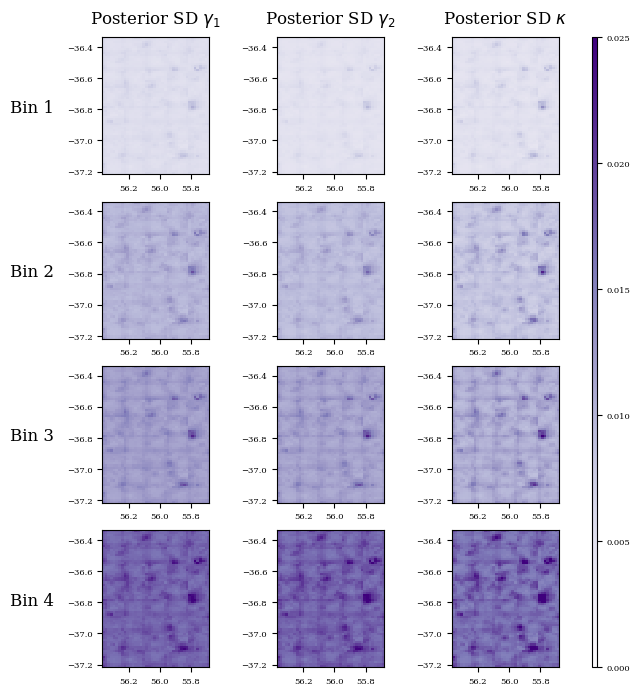

In [21]:
fig, ax = plt.subplots(4, 3, figsize=(5.5, 7))
fontsize = 12
ticklabelsize = 6
vmin = 0.0
vmax = 0.025
cmap = "Purples"

for b in range(4):
    # Shear 1 std
    _ = ax[b, 0].imshow(
        shear1_std_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Shear 2 std
    _ = ax[b, 1].imshow(
        shear2_std_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Convergence std
    tmp = ax[b, 2].imshow(
        convergence_std_sorted[..., b].cpu(),
        extent=extent,
        origin="lower",
        interpolation=interpolation,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

_ = ax[0, 0].set_title(r"Posterior SD $\gamma_1$", fontsize=fontsize, pad=10)
_ = ax[0, 1].set_title(r"Posterior SD $\gamma_2$", fontsize=fontsize, pad=10)
_ = ax[0, 2].set_title(r"Posterior SD $\kappa$", fontsize=fontsize, pad=10)
_ = ax[0, 0].set_ylabel("Bin 1", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[1, 0].set_ylabel("Bin 2", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[2, 0].set_ylabel("Bin 3", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)
_ = ax[3, 0].set_ylabel("Bin 4", fontsize=fontsize, rotation=0, labelpad=25, y=0.425)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize=ticklabelsize)
fig.colorbar(tmp, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

for a in ax.flat:
    a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.savefig(
    "figures/posteriorstdevmaps.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0
)